Installing the clip module

In [1]:
!pip install git+https://github.com/openai/CLIP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP to /tmp/pip-req-build-oc4y574w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP /tmp/pip-req-build-oc4y574w
  Resolved https://github.com/openai/CLIP to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=93269e45ee7ba74dded809386bdf6cde0f1aa1ea3cde24d51dc16c7439783644
  Stored in directory: /tmp/pip-ephem-wheel-cache-9rj80y5x/wheels/36/76/30/6f371f2bcd119a5b9e0b3605fa8b3ca0f629a9162b91c3d9e2
Successfully built clip


In [2]:
from tqdm.notebook import trange
import torch
from torchvision import transforms
import clip

In [8]:
device ='cuda'
cutn =  16
shape = (256, 256)
lr = 0.03
steps = 500
clip_model = "ViT-B/32"
prompt = "a teddy bear riding a bike"

In [9]:
image=torch.rand((1, 3, shape[0], shape[1]), device=device, requires_grad=True)

opt=torch.optim.Adam((image,),lr)

f=transforms.Compose([lambda x:torch.clamp((x+1)/2,min=0,max=1),transforms.RandomAffine(degrees=60, translate=(0.1, 0.1)),transforms.RandomGrayscale(p=0.2),
                      transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01),transforms.Resize(224)])

m=clip.load(clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

embedding=m.encode_text(clip.tokenize(prompt).to(device))

def total_variation_loss(img):
    yv = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
    xv = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
    return (yv+xv)/(1*3*shape[0]*shape[1])

def spherical_distance_loss(x, y):
    return (torch.nn.functional.normalize(x, dim=-1) - torch.nn.functional.normalize(y, dim=-1)).norm(dim=-1).div(2).arcsin().pow(2).mul(2).mean()

In [10]:
for i in trange(steps):
    opt.zero_grad()
    clip_in = m.encode_image(torch.cat([f(image.add(1).div(2)) for _ in range(cutn)]))
    loss = spherical_distance_loss(clip_in, embedding.unsqueeze(0)) + (image - image.clamp(-1, 1)).pow(2).mean()/2 + total_variation_loss(image)
    loss.backward()
    opt.step()

  0%|          | 0/500 [00:00<?, ?it/s]

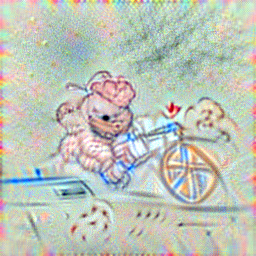

In [11]:
transforms.ToPILImage()(image.squeeze(0).clamp(-1,1)/2+.5)